In [ ]:
#!pip install tiktoken

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, tiktoken, eli5, nltk, torch

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import TensorDataset, DataLoader

pd.set_option('display.max_colwidth', None)

# Pré-traitement

## Unifier les datasets

In [9]:
topics = os.listdir("/kaggle/input/poemsdataset/topics")
df_topics_list = []
for topic in topics:
    files = os.listdir(f"/kaggle/input/poemsdataset/topics/{topic}")
    df_topic = pd.DataFrame(columns=["poem", "labels"])
    i = 0
    for filename in files:
        with open(f"/kaggle/input/poemsdataset/topics/{topic}/{filename}", encoding="utf8") as f:
            df_topic.loc[i] = {"poem": f.read(), "labels": topic}
        i += 1
    df_topics_list.append(df_topic)

df_topics = pd.concat(df_topics_list, ignore_index=True)
df_topics.tail()

,poem,labels
14330,"I don't know when I was born,\nMaybe when humanity didn't exist.\nI was lost, in the senses of the insentient beings;\nAlways trying to find something.\nThen came the humans, and I found my worth.\nI found my place in the stone man's child\nAnd the warmth of the fire made,\nSince then I am multiplied.\nI am the newborn's cry and the old man's last grin;\nThe blue of the ocean, red of the fire;\nHalf Bent bough of the golden tree to the ground,\nYellow no more, I am coloured brown\nOnce the air smelled of me, and the soil whispered my name;\nI was serenity, I was beauty;\nBut for years I was harmed\nAnd my luster has happened to dim.\nAnd then came the bullets\nWith their sharp faces drilling my reality;\nI felt lonely, for no one remembered me,\nPuffed with the grey smoke far I went\nNow I doubt myself, have I ever existed?\nBut when that sudden qualm would arise\nI would find myself in the smile of a mother\nWith her child, I am still alive…",innocence
14331,"Who says the Christ was crucified?\nWho says the innocence ever died?\nChrist just came to be our guide,\nAfter the message he did hide.\nInnocence is her Master’s bride,\nLet your eyes be open wide;\nSan innocence life takes not stride,\nSan a villain the drama doesn’t glide.\nPleasures and pains are lighted fools,\nThey are just life’s drama’s tools;\nIts stage is just a duality’s pool,\nThat is why Trinity our minds rule.\nNothing dies, nothing ever crucified,\nThe fault is with us, we are two eyed;\nUnite with the One and ride your pride,\nLet us be Radha, Lord Krishana’s bride.\nThis poem was composed in response to Vaibhav Shah’s composition ‘INNOCENCE CRUCIFIED’",innocence
14332,Does anyone listen\nfor the cries\nof the innocent\nDoes anyone care\nabout the young\nand the old\nDo we have to pretend\nwe didn't hear\nthe babies cry\nDo we have to pretend\nsomeone cares for the old\nOr do we do something now\nFor the young\nand the old,innocence
14333,"You crawled into my bed\nTo make love for the first time\nThen you asked for my help\nYou needed some more wine\nYou said I was the only one\nTo help you in this case\n“Help me get my wife back”\nYou said with such disgrace\nA friend from my teenage years\nI was so naive and stunned\nYou could not have hurt me more\nIf you had shot me with a gun\nYou cried, you begged, you pleaded\n“But you are my life-long friend”\nI should have known that moment\nThis had to be the end\nYou stole from me something\nThat could not be replaced\nMy innocence gone forever\nIt hurt so much to face\nI could have gone a lifetime\nNever seeing that dark side\nFor years you and everyone\nHad been so good to hide",innocence
14334,"People who describe themselves,\nAs repeatedly victimized...\nAre always on the scene,\nProviding the same evidence...\nThat never seems to change,\nA depiction of their innocence.\nAnd who has been abusive to them,\nOffensive, cruel and mean.\n'And you say,\nYou have no idea why this has happened? '\n~I wish I had a 'hint' or a single clue.\nEveryone else accepts what it is that I do.~\n'Everyone else but just a few, huh? '\n~What do you mean by that? ~",innocence


## Lowercase, Apostrophes, \r and \n, ponctuations, stop words

In [10]:
# Lowercase
df_topics["poem"] = df_topics["poem"].str.lower()

# Apostrophes
df_topics["poem"] = df_topics["poem"].str.replace("'", "", regex=False)
df_topics["poem"] = df_topics["poem"].str.replace("’", "", regex=False)

# \r and \n (ceux du début)
df_topics["poem"] = df_topics["poem"].str.replace("\r", " ")
df_topics["poem"] = df_topics["poem"].str.strip("\n")
df_topics = df_topics[df_topics["poem"] != ""]

# Ponctuations
df_topics["poem"] = df_topics["poem"].str.replace("[^\w\s]", " ", regex=True)

# Stopwords
stopwords = set(stopwords.words('english'))
df_topics["poem"] = df_topics["poem"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [11]:
df_topics.tail()

,poem,labels
14330,dont know born maybe humanity didnt exist lost senses insentient beings always trying find something came humans found worth found place stone mans child warmth fire made since multiplied newborns cry old mans last grin blue ocean red fire half bent bough golden tree ground yellow coloured brown air smelled soil whispered name serenity beauty years harmed luster happened dim came bullets sharp faces drilling reality felt lonely one remembered puffed grey smoke far went doubt ever existed sudden qualm would arise would find smile mother child still alive,innocence
14331,says christ crucified says innocence ever died christ came guide message hide innocence masters bride let eyes open wide san innocence life takes stride san villain drama doesnt glide pleasures pains lighted fools lifes dramas tools stage dualitys pool trinity minds rule nothing dies nothing ever crucified fault us two eyed unite one ride pride let us radha lord krishanas bride poem composed response vaibhav shahs composition innocence crucified,innocence
14332,anyone listen cries innocent anyone care young old pretend didnt hear babies cry pretend someone cares old something young old,innocence
14333,crawled bed make love first time asked help needed wine said one help case help get wife back said disgrace friend teenage years naive stunned could hurt shot gun cried begged pleaded life long friend known moment end stole something could replaced innocence gone forever hurt much face could gone lifetime never seeing dark side years everyone good hide,innocence
14334,people describe repeatedly victimized always scene providing evidence never seems change depiction innocence abusive offensive cruel mean say idea happened wish hint single clue everyone else accepts everyone else huh mean,innocence


nb poems in topics: 14335


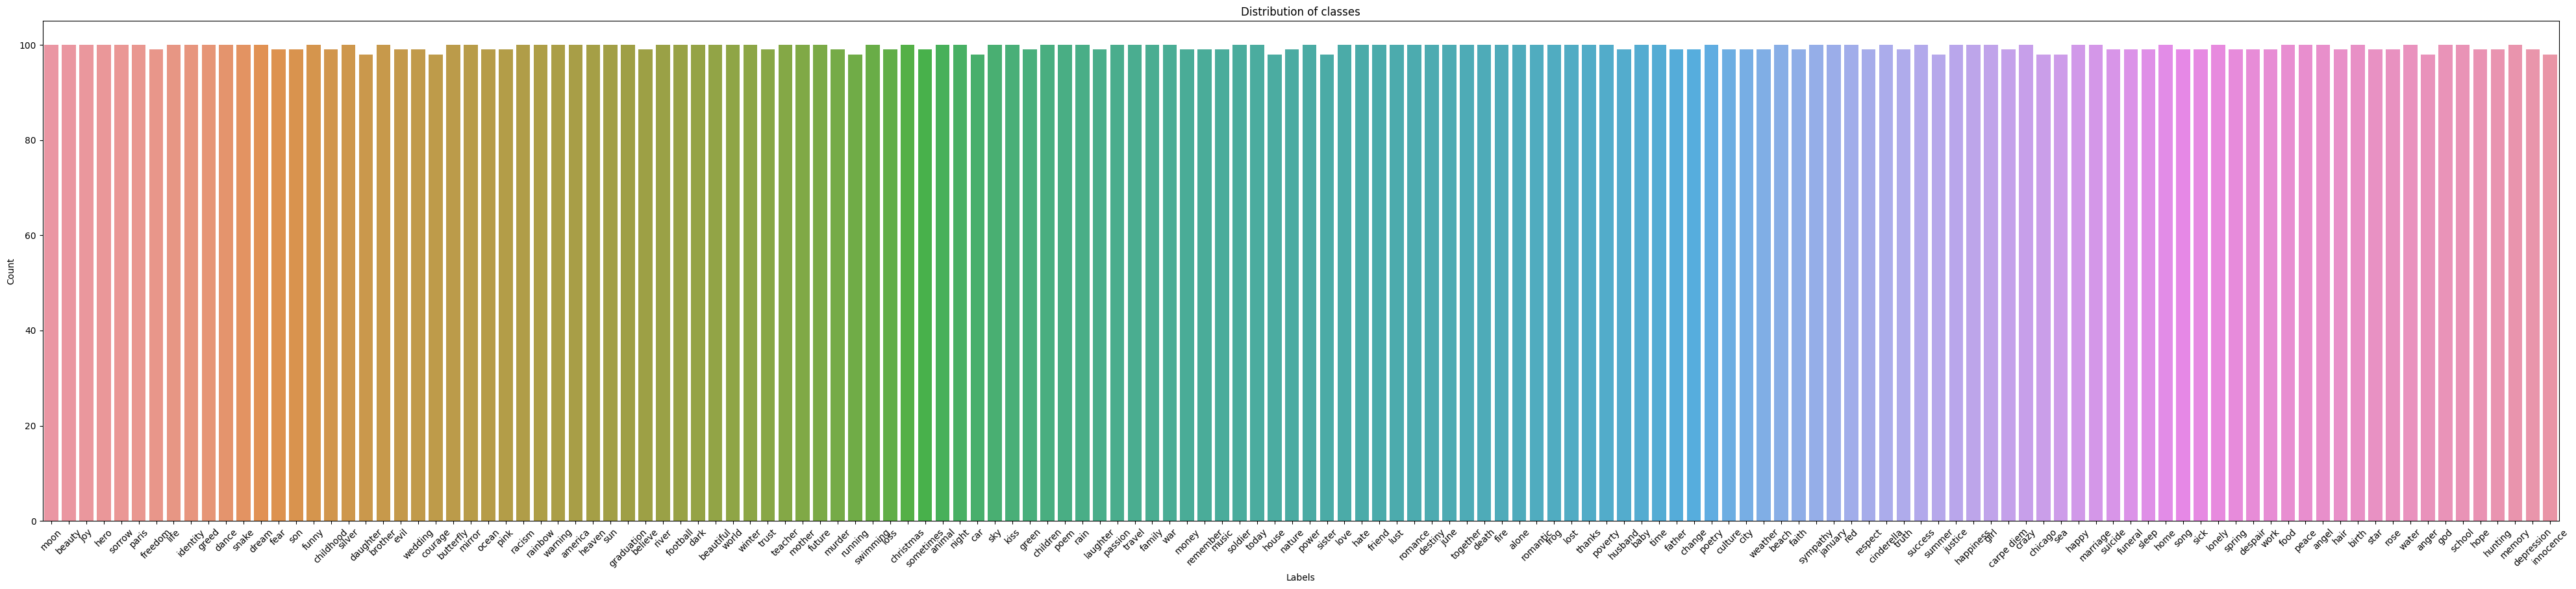

"\nplt.figure(figsize=(50, 10))\nsns.countplot(x='labels', data=df_PoetryFoundationData)\nplt.title('Distribution of classes') \nplt.xlabel('Labels')\nplt.ylabel('Count')\nplt.xticks(rotation=45)\nplt.show()\n\nplt.figure(figsize=(50, 10))\nsns.countplot(x='labels', data=df_topics)\nplt.title('Distribution of classes') \nplt.xlabel('Labels')\nplt.ylabel('Count')\nplt.xticks(rotation=45)\nplt.show()\n"

In [12]:
print(f"nb poems in topics: {len(df_topics)}")
#print(f"nb poems in poetry foundation: {len(df_PoetryFoundationData)}")

plt.figure(figsize=(50, 10))
sns.countplot(x='labels', data=df_topics)
plt.title('Distribution of classes') 
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Model & Fitting

## Training Word2vec

In [14]:
X_list = list(df_topics["poem"])
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [15]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [16]:
wv = KeyedVectors.load("/kaggle/working/word2vec.wordvectors", mmap='r')
sims = wv.most_similar('racist', topn=10)
sims

[('stacked', 0.5237152576446533),
 ('nestled', 0.520535409450531),
 ('enfolding', 0.5190216898918152),
 ('steadily', 0.5085099339485168),
 ('interrupted', 0.5067174434661865),
 ('cu', 0.49206069111824036),
 ('augment', 0.4859408736228943),
 ('gladdens', 0.47683483362197876),
 ('curses', 0.4742704927921295),
 ('wasp', 0.4633301794528961)]

## Load pretrained Word2vec models

In [17]:
pretrained_wv = gensim.downloader.load('glove-twitter-100')
pretrained_wv

[==================================================] 100.0% 387.1/387.1MB downloaded


In [18]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [19]:
document_vector("hello i'm christophe", wv)

array([-0.0026864 , -0.02022397, -0.00552006,  0.01035762, -0.01026534,
        0.01097129,  0.00040992, -0.00586468,  0.00774188, -0.01571909,
        0.00190992, -0.00600561,  0.01889254, -0.01739108, -0.01013403,
        0.01721032,  0.00753022,  0.02010575, -0.01603879,  0.01631203,
        0.01848502,  0.01708811,  0.00591847,  0.01379453,  0.0081077 ,
        0.0178961 ,  0.01017501, -0.00147981, -0.00037816, -0.01141788,
        0.00481764, -0.01132033,  0.00687991,  0.01994331,  0.01517497,
       -0.007907  ,  0.00198999, -0.01269919,  0.00181082,  0.01861868,
       -0.00355548, -0.01059378,  0.00315212,  0.00877921,  0.00919203,
       -0.00676996, -0.01985729,  0.00270175, -0.01174273, -0.01246493],
      dtype=float32)

In [20]:
document_vector("hello i'm christophe", pretrained_wv)

array([ 4.4119954e-02,  2.5914997e-02, -3.8342491e-02,  3.0954498e-01,
       -3.0992025e-01, -2.3509499e-02,  2.0824239e-02, -8.4839255e-02,
       -1.6701874e-01, -3.3749938e-03, -1.9882837e-01, -9.5597506e-02,
       -3.2976999e+00, -6.1912499e-02, -9.5575005e-03, -1.5902502e-02,
        1.8393874e-01, -1.5495598e-01, -5.3045750e-01,  1.3674751e-01,
        2.2683750e-01, -6.3893849e-01, -6.3707024e-02, -3.6285251e-01,
        1.0785875e-01, -5.4867005e-01,  7.6076999e-02,  2.0618749e-01,
        1.6749749e-01, -3.3292753e-01, -2.5459999e-01, -1.9787498e-02,
       -5.2626401e-01, -1.7145249e-01,  1.5125014e-03,  2.8741848e-01,
       -1.6669600e-01,  2.1532748e-02,  4.0824500e-01,  1.7912501e-01,
       -9.5565754e-01, -4.5286249e-02,  1.3977000e-01,  2.7618325e-01,
       -1.1679300e-01,  7.7807501e-02,  1.9218500e-01, -6.1196005e-01,
       -2.7362242e-01,  1.3037500e-01, -1.7370252e-01,  1.3678105e-01,
       -1.0798100e-01, -3.0793700e-01,  1.2054753e-01,  1.4523749e-01,
      

In [54]:
X = df_topics['poem']
y = df_topics['labels']

label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

LogisticRegressionModel(
  (linear): Linear(in_features=68125, out_features=144, bias=True)
)
Epoch [1/20], Loss: 4.6469
Precision: 0.4051, Recall: 0.2361, F1 Score: 0.2593
Epoch [2/20], Loss: 3.1723
Precision: 0.3431, Recall: 0.2689, F1 Score: 0.2750
Epoch [3/20], Loss: 2.0636
Precision: 0.3167, Recall: 0.2724, F1 Score: 0.2735
Epoch [4/20], Loss: 1.2381
Precision: 0.3087, Recall: 0.2762, F1 Score: 0.2751
Epoch [5/20], Loss: 1.0802
Precision: 0.3084, Recall: 0.2776, F1 Score: 0.2777
Epoch [6/20], Loss: 0.6560
Precision: 0.3119, Recall: 0.2811, F1 Score: 0.2825
Epoch [7/20], Loss: 1.1339
Precision: 0.3121, Recall: 0.2811, F1 Score: 0.2830
Epoch [8/20], Loss: 0.5272
Precision: 0.3171, Recall: 0.2846, F1 Score: 0.2873
Epoch [9/20], Loss: 0.5423
Precision: 0.3200, Recall: 0.2871, F1 Score: 0.2905
Epoch [10/20], Loss: 0.3127
Precision: 0.3200, Recall: 0.2878, F1 Score: 0.2917
Epoch [11/20], Loss: 0.2615
Precision: 0.3252, Recall: 0.2912, F1 Score: 0.2959
Epoch [12/20], Loss: 0.3120
Precisi

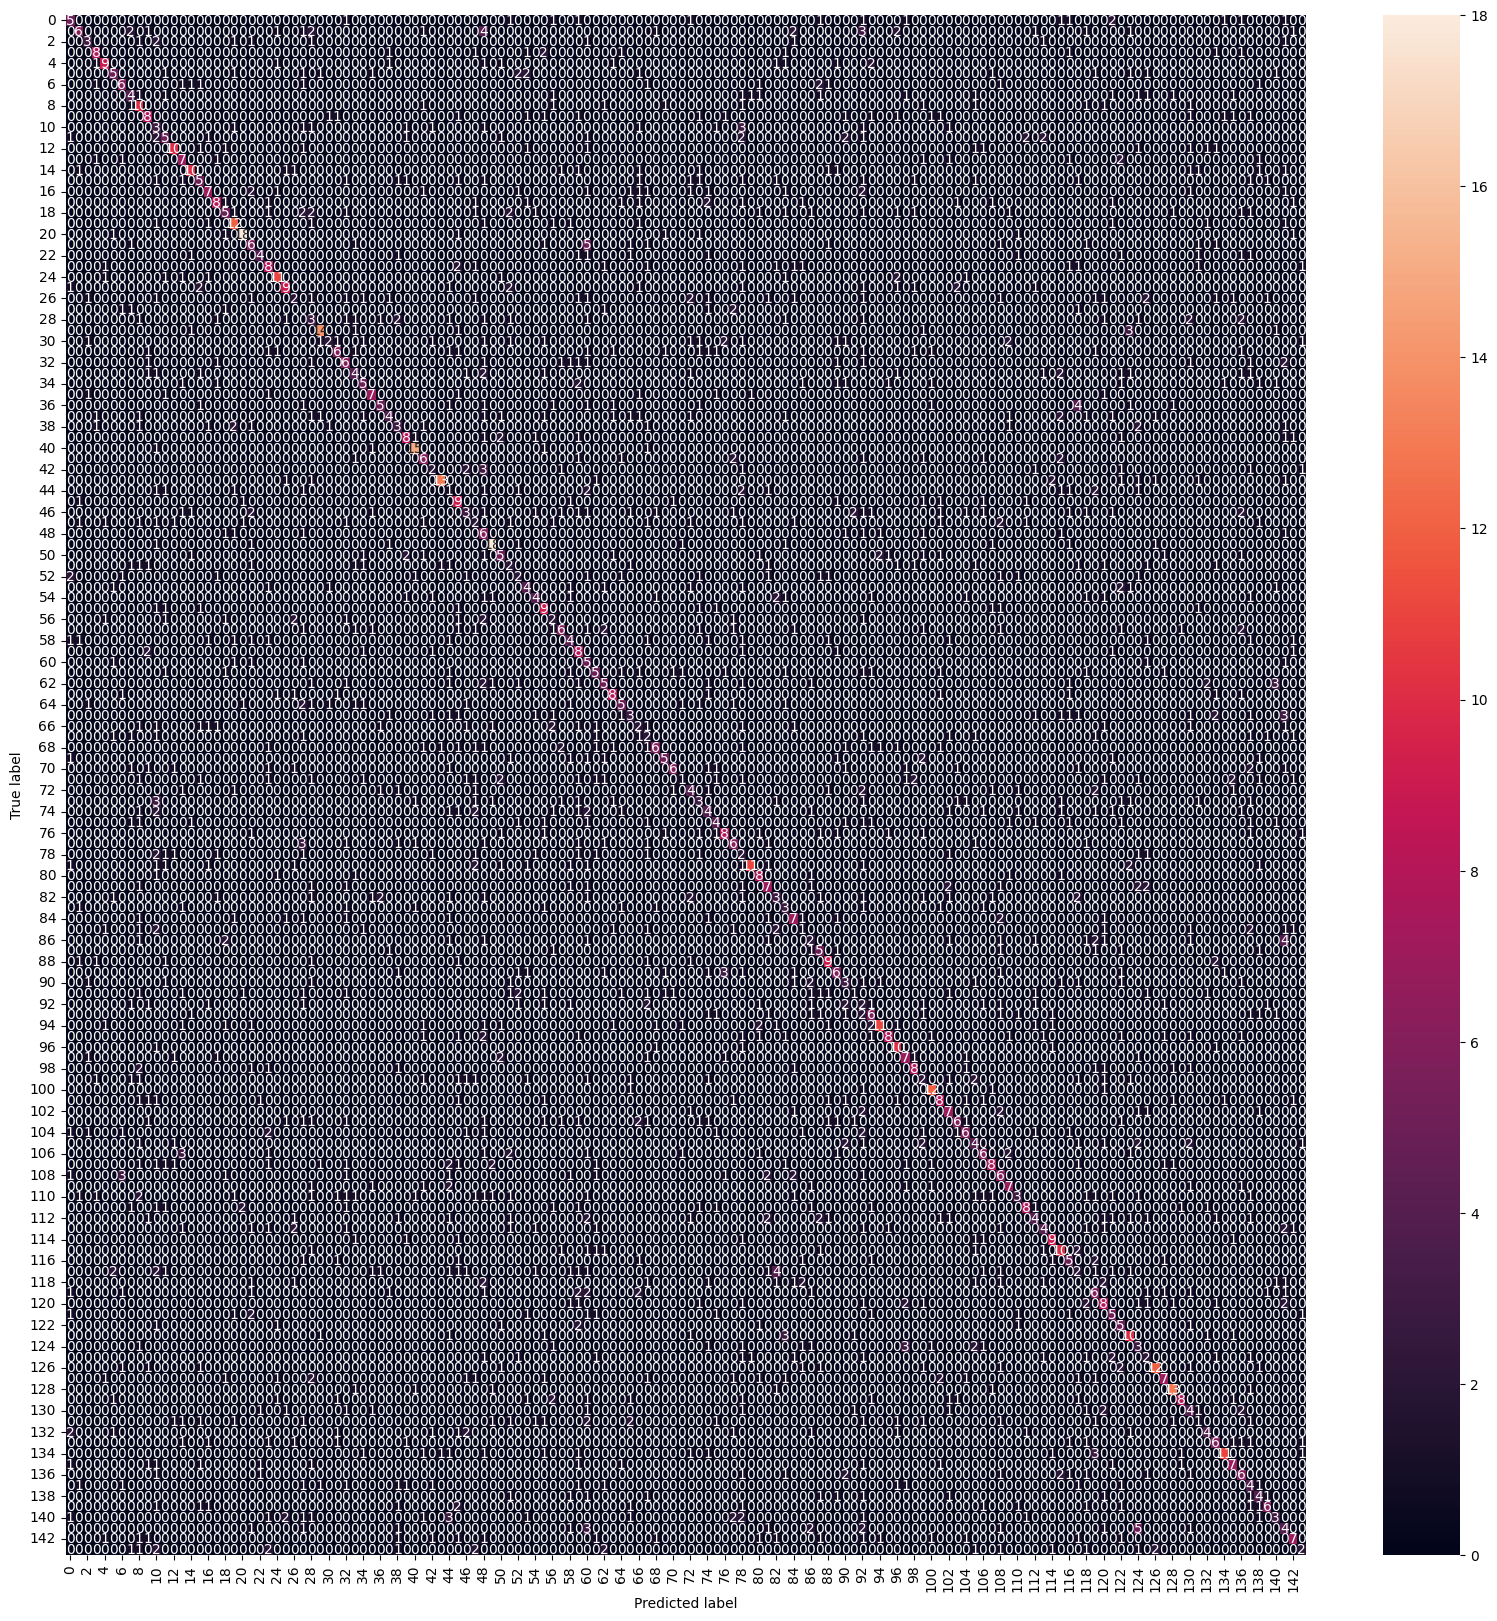

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [90]:
from sklearn.metrics import classification_report, accuracy_score

class_names = list(set(y.values))
report = classification_report(all_labels, all_predictions, target_names=class_names)

accuracy = accuracy_score(all_labels, all_predictions)

print("Score de précision :", accuracy)
print("Rapport de classification :\n", report)

Score de précision : 0.2961283571677712
Rapport de classification :
               precision    recall  f1-score   support

   beautiful       0.25      0.25      0.25        20
        fear       0.43      0.20      0.27        30
        moon       0.30      0.23      0.26        13
        star       0.50      0.44      0.47        18
    football       0.53      0.45      0.49        20
      poetry       0.36      0.25      0.29        20
  depression       0.35      0.33      0.34        18
        home       0.24      0.22      0.23        18
   happiness       0.27      0.48      0.34        21
   innocence       0.35      0.32      0.33        25
       trust       0.07      0.19      0.11        16
       greed       0.25      0.24      0.24        21
     believe       0.59      0.48      0.53        21
     despair       0.32      0.44      0.37        16
     teacher       0.59      0.43      0.50        23
      memory       0.28      0.22      0.24        23
      family